In [14]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from genaibook.core import show_images

In [5]:
class FreyFaceDataset(Dataset):
    def __init__(self, path="frey_rawface.mat"):
        data = scipy.io.loadmat(path)["ff"].T
        self.images = data.reshape(-1, 28, 20).astype(np.float32) / 255.0

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx]).unsqueeze(0)  # [1, 28, 20]
        return img

In [6]:
train_dataset = FreyFaceDataset("frey_rawface.mat")
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

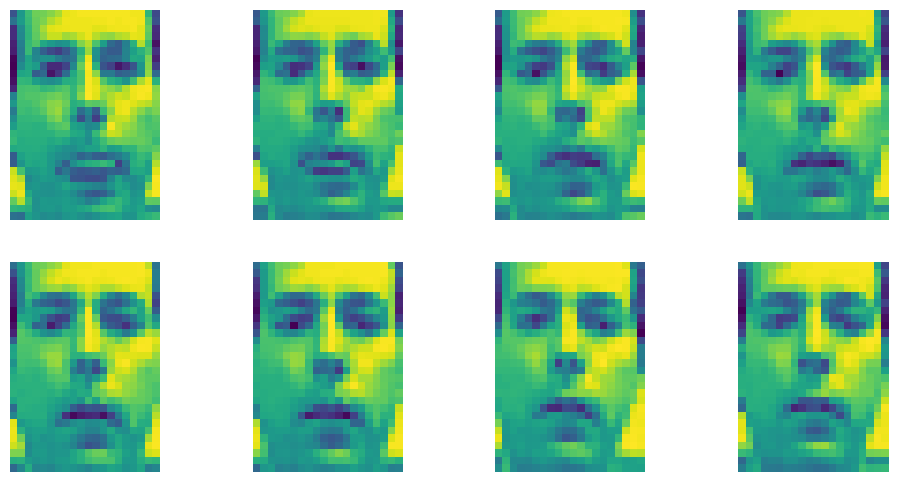

In [9]:
sample_images = [train_dataset[i].squeeze(0).numpy() for i in range(8)]
show_images(sample_images)

In [10]:
import matplotlib as mpl

In [11]:
mpl.rcParams["image.cmap"] = "gray_r"

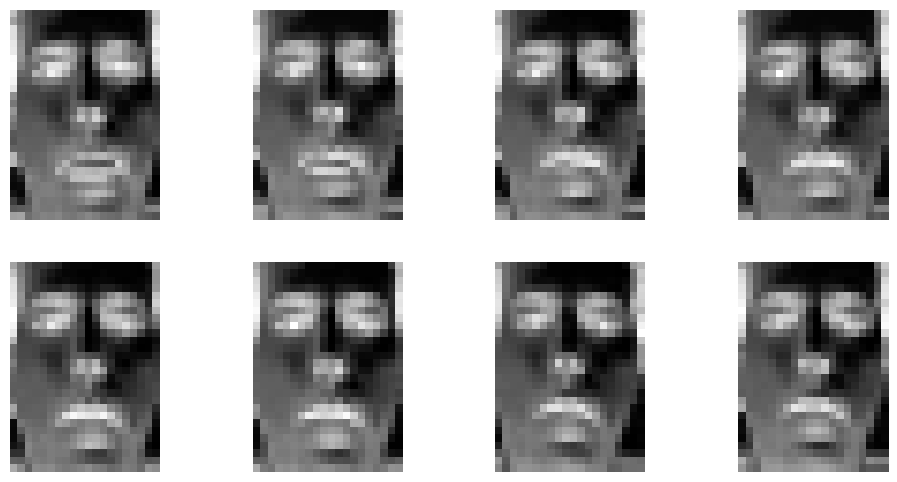

In [12]:
show_images(sample_images)

# Encoder

In [15]:
# Shuffle with split
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(1337))


In [16]:
x = train_dataset[0]  # shape: [1, 28, 20]
print(x.min().item(), x.max().item())

0.13333334028720856 0.9098039269447327


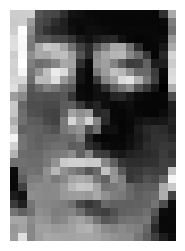

In [17]:
show_images([x.squeeze(0).numpy()])

In [18]:
bs = 64
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

In [19]:
import torch.nn as nn

In [20]:
# Makes a 2D convolutional layer, then appends a normalization layer and nonlinearity (ReLU)
# NOTE: normalization is based on mean and standard deviation to make sure input stays in a predictable range
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,   
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [ ]:
# converts 28 x 28 images into vectors of 16 numbers
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256)
        self.conv3 = conv_block(256, 512)
        self.conv4 = conv_block(512, 1024)
        self.linear = nn.Linear(1024, 16)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) 
        x = self.conv4(x) 
        # Keep batch dimension when flattening
        x = self.linear(x.flatten(start_dim=1)) # bs 16
        return x

In [26]:
train_dataset[0].shape

torch.Size([1, 28, 20])

In [27]:
in_channels = 1
x = train_dataset[0][None, :]
encoder = Encoder(in_channels).eval()

In [28]:
encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [29]:
encoded

tensor([[-6.3297e-03,  2.2889e-02,  5.6489e-03,  8.6640e-04, -2.2859e-02,
          4.7198e-03,  2.6844e-02,  3.3544e-02, -5.8893e-03, -1.4049e-02,
         -1.1243e-05, -3.1519e-02, -1.6048e-02, -1.4135e-03,  2.6738e-02,
         -2.3028e-02]], grad_fn=<AddmmBackward0>)

In [30]:
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels=1)(batch)
batch.shape, encoded.shape

(torch.Size([64, 1, 28, 20]), torch.Size([64, 16]))

# Decoder

In [33]:
def conv_transpose_block(
        in_channels, 
        out_channels, 
        kernel_size=3, 
        stride=2, 
        padding=1, 
        output_padding=0, 
        with_act=True
    ):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding
        )
    ]
    if with_act:
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
    return nn.Sequential(*modules)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.linear = nn.Linear(16, 1024 * 7 * 5)

        self.t_conv1 = nn.ConvTranspose2d(
            1024, 512,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.t_conv2 = nn.ConvTranspose2d(
            512, out_channels,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.output_act = nn.Sigmoid()

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.view(bs, 1024, 7, 5)
        x = self.t_conv1(x)
        x = self.t_conv2(x)
        return self.output_act(x)


    
decoded_batch = Decoder(x.shape[0])(encoded)
decoded_batch.shape


torch.Size([64, 1, 28, 20])

# AutoEncoder

In [52]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = Decoder(in_channels)

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [53]:
model = AutoEncoder(1)

# Summary of AutoEncoder Model

In [54]:
import torchsummary

In [55]:
torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [56]:
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange
from genaibook.core import get_device

In [57]:
num_epochs = 10
lr = 1e-4
device = get_device()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

In [58]:
losses = [] # List to store the loss values for plotting

In [59]:
for _ in (progress := trange(num_epochs, desc="Training")):
    for _, batch in (inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
        batch = batch.to(device)
        preds = model(batch)
        loss = F.mse_loss(preds, batch)
        inner.set_postfix(loss=f'{loss.cpu().item():.3f}')
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    progress.set_postfix(loss=f'{loss.cpu().item():.3f}', lr=f'{lr:.0e}')

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

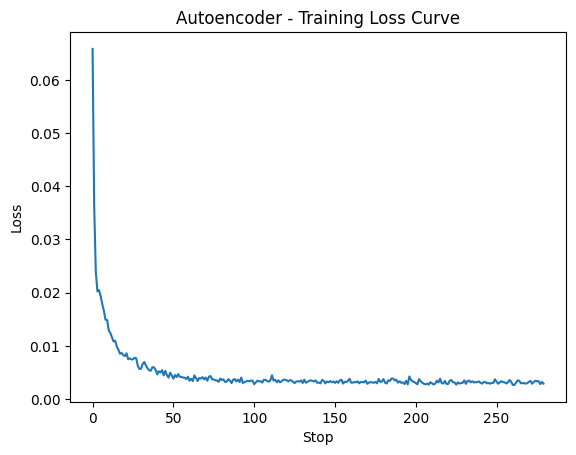

In [60]:
plt.plot(losses)
plt.xlabel("Stop")
plt.ylabel("Loss")
plt.title("Autoencoder - Training Loss Curve")
plt.show()

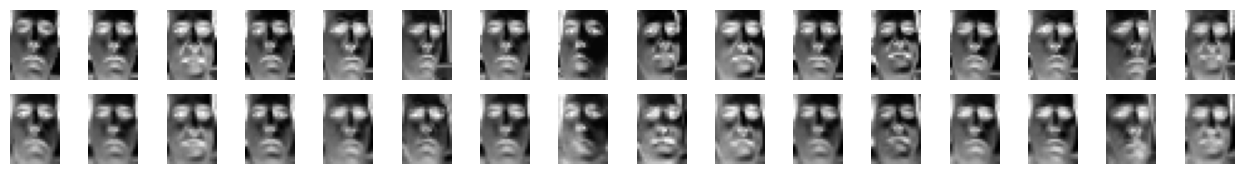

In [61]:
# Reconstruct images using our model
eval_bs = 16
eval_dataloader = DataLoader(val_dataset, batch_size=eval_bs)
model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = model(eval_batch.to(device)).cpu()

batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

# VAEs: Representations with Gaussian Spread (instead of points)

In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024)
        )

        self.mu = nn.Linear(1024, latent_dims)
        self.logvar = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)      
        x = x.view(bs, -1)              
        mu = self.mu(x)                     
        logvar = self.logvar(x)                
        return mu, logvar

In [ ]:
class VAEDecoder(nn.Module):
    def __init__(self, out_channels, latent_dims):
        super().__init__()
        self.linear = nn.Linear(latent_dims, 1024 * 7 * 5)

        self.t_conv1 = nn.ConvTranspose2d(
            1024, 512,
            kernel_size=4,
            stride=2,
            padding=1
        ) 

        self.t_conv2 = nn.ConvTranspose2d(
            512, out_channels,
            kernel_size=4,
            stride=2,
            padding=1
        ) 

        self.output_act = nn.Sigmoid()

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.view(bs, 1024, 7, 5)
        x = self.t_conv1(x)
        x = self.t_conv2(x)
        return self.output_act(x)


In [ ]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = VAEEncoder(in_channels, latent_dims)
        self.decoder = VAEDecoder(in_channels, latent_dims)

    def encode(self,x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)

        # Sample from distribution
        std = torch.exp(0.5 * logvar)
        z = self.sample(mu, std)

        # Decode the latent point to pixel space
        reconstructed = self.decode(z)

        return reconstructed, mu, logvar
    
    def sample(self, mu, std):
        # Sample from N(0, I), translate and scale
        # Reparameterization
        eps = torch.randn_like(std)
        return mu + eps * std

In [74]:
def vae_loss(batch, reconstructed, mu, logvar):
    bs = batch.shape[0]

    # Reconstruction loss from the pixels - 1 per image
    reconstruction_loss = F.mse_loss(
        reconstructed.reshape(bs, -1),
        batch.reshape(bs, -1),
        reduction="none"
    ).sum(dim=-1)

    # KL-divergence loss, per input image
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

    # Combine both losses and get the mean across images
    loss = (reconstruction_loss + kl_loss).mean(dim=0)

    return (loss, reconstruction_loss, kl_loss)

In [75]:
# Train model
def train_vae(model, num_epochs=10, lr=1e-4):
    model = model.to(device)
    losses = {
        'loss': [],
        'reconstruction_loss': [],
        'kl_loss': [],
    }

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through model
            reconstructed, mu, logvar = model(batch)

            # Compute losses
            loss, reconstruction_loss, kl_loss = vae_loss(batch, reconstructed, mu, logvar)

            # Display loss and store for plotting
            inner.set_postfix(loss=f'{loss.cpu().item():.3f}')
            losses['loss'].append(loss.item())
            losses['reconstruction_loss'].append(reconstruction_loss.mean().item())
            losses['kl_loss'].append(kl_loss.mean().item())

            # Update model parameters based on the total loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        progress.set_postfix(loss=f'{loss.cpu().item():.3f}', lf=f'{lr:.0e}')
    return losses

In [ ]:
vae_model = VAE(in_channels=1, latent_dims=16)
losses = train_vae(vae_model, num_epochs=10, lr=1e-4)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

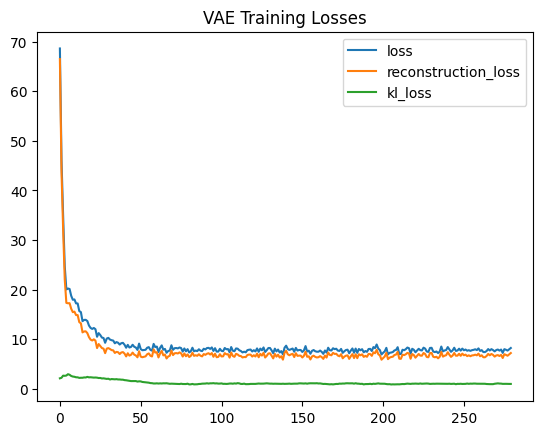

In [81]:
for k,v in losses.items():
    plt.plot(v, label=k)
plt.title("VAE Training Losses")
plt.legend()

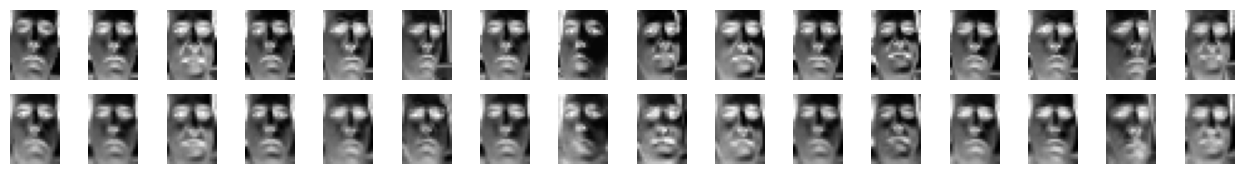

In [82]:
vae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted, mu, logvar = (v.cpu() for v in vae_model(eval_batch.to(device)))
    batch_vs_pres = torch.cat((eval_batch, predicted))
    show_images(batch_vs_preds, imsize=1, nrows=2)

# Compare AutoEncoder to VAE

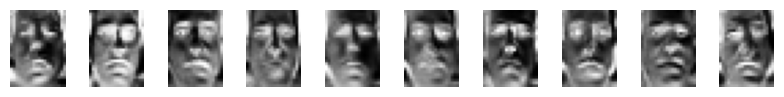

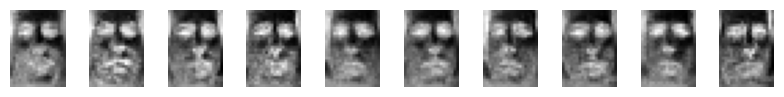

In [ ]:
z = torch.randn(10, 16).to(device)

ae_decoded = model.decode(z).cpu()
vae_decoded = vae_model.decode(z).cpu()

show_images(ae_decoded, imsize=1, nrows=1)
show_images(vae_decoded, imsize=1, nrows=1)